## Low-rank iterative reconstruction ##

#### M D Sacchi ####
#### [Signal Analysis and Imaging Group](https://saig.physics.ualberta.ca/doku.php), Physics, University of Alberta ####

The following script shows the solution of  the matrix completion problem via iterative rank reduction. The rank of the uncorrupted image is assumed to be $p=50$.  The algorithm follows the method proposed by Oropeza and Sacchi (2011) to reconstruct seismic records

$$ d^{k} =  d^{obs}+ (1-\, S)\,\circ\,{\cal R} \,[\, d^{k-1}\,]$$

where ${\cal R}[x]$ is the low rank projection operator and $S$ is the sampling operator given  by

\begin{equation}
S(n,m) = \left\{  \begin{array}{ll} 
                                  1 &\text{Observation/Rating exists}\\
                                  0 &\text{Missing Observation/Rating}\,.
              \end{array}\right.
\end{equation}
            
If $x$ is a full rank matrix of size $m \times n$ then $y = {\cal R}[x]$ is its rank-p approximation.  Rank reduction can be implemented via the Singular Value Decomposition (SVD) or, as below, via the Randomized SVD (rSVD).  rSVD is faster than SVD when $p<<max(m,n)$ 


#### References ####

Oropeza V and   M D Sacchi, 2011,Simultaneous seismic data denoising and reconstruction via multichannel singular spectrum analysis:  Geophysics ,76(3), V25–V32 [PDF](http://library.seg.org/doi/abs/10.1190/1.3552706)






In [1]:
function rSVD(A,k)
    
# Rank Reduction via Ramdomized SVD 
# A: Matrix
# k: approximation to desired rank
# B = rank_reduction(A,k) is the reduced-rank approximation of A
     
 l = 2*k
 (m,n) = size(A);
 G = randn(l,m);
 R = G*A;
 (Uq,Eq,Vq) = svd(R');
 Q = Uq[:,1:k];
 T = A*Q;
 (U,E,W) = svd(T);
 V = Q*W;
 B = U*diagm(E)*V';

 return B
end


rSVD (generic function with 1 method)

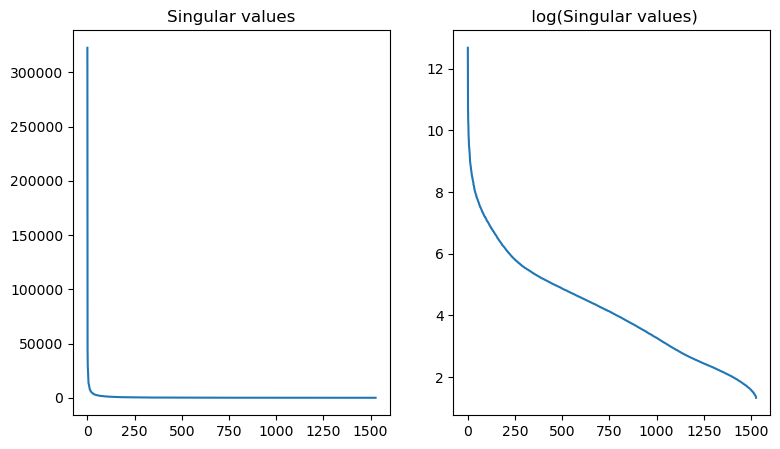

PyObject Text(0.5, 1.0, ' log(Singular values)')

In [2]:
using PyPlot, LinearAlgebra

# First read the uncorrupted image of Constantite 

 #filename = download("http://seismic.physics.ualberta.ca/data/finger.bin","finger.bin");
filename="finger.bin"
 hf = open(filename,"r")
 n1 = 2165
 n2 = 1528


data = Array{Float64}(undef, n1, n2)
read!("finger.bin", data)

figure("2",figsize=(9,5))
(U,Sing,V) = svd(data)
subplot(121);plot((Sing));title("Singular values")
subplot(122);plot(log.(Sing));title(" log(Singular values)")


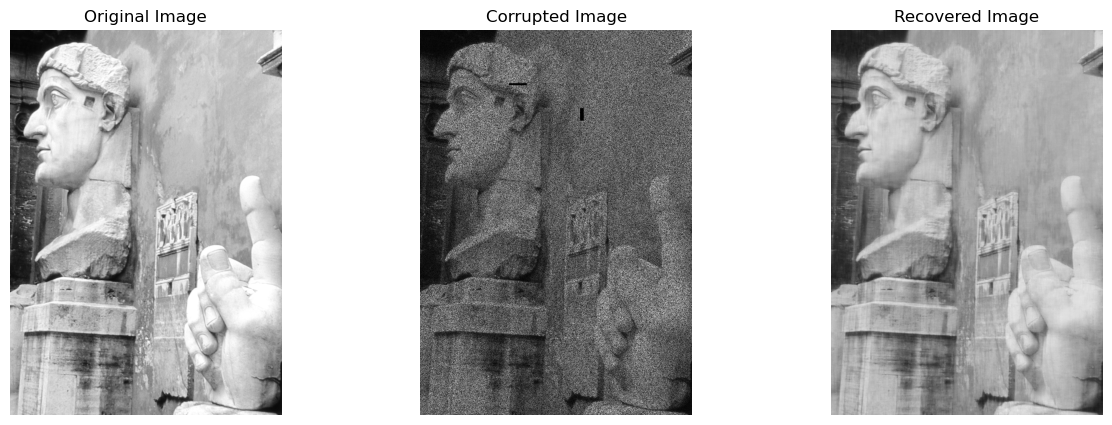

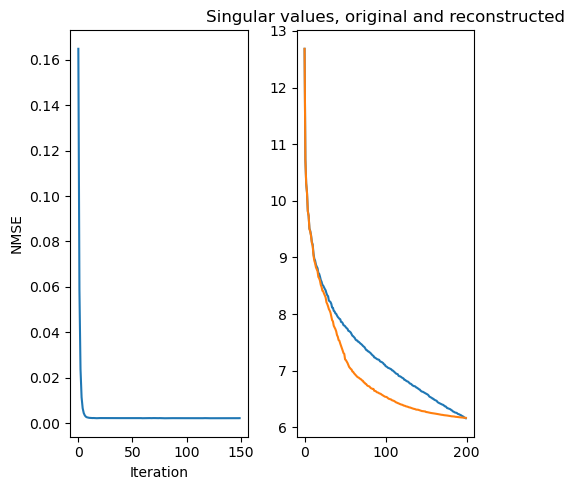

In [3]:
# The image is randomly decimated via the operator S 

prob = 0.5

S = ones(n1,n2)
for i = 1:n1
    for j=1:n2
        r = rand()
        if r<prob
            S[i,j]=0.0
        end
    end
end
S[300:310,500:600].=0.0
S[440:510,900:920].=0.0
 d_obs = S.*data
     d = copy(d_obs)


     

# Iterative reconstruction starts here 

max_iter = 150; 
NMSE = zeros(max_iter)
p = 50;                                  #    I assume the original images was of rank 50
for k = 1:max_iter
    R = rSVD(d,p)                         #    Apply fast rank reduction via randomized SVD
    d = d_obs + (ones(n1,n2)-S).*R;
    e = d-data;
    NMSE[k] = sum(e[:].^2) / sum(data[:].^2)
end
    
figure("1",figsize=(15,5))
subplot(131); imshow(data,  cmap="gray"); axis("off"); title("Original Image")
subplot(132); imshow(d_obs, cmap="gray"); axis("off"); title("Corrupted Image")
subplot(133); imshow(d    , cmap="gray"); axis("off"); title("Recovered Image")
figure("2",figsize=(5,5))
subplot(121);plot(NMSE);xlabel("Iteration");ylabel("NMSE")
(U,Sing_r,V) = svd(d)
subplot(122);plot(log.(Sing[1:200]));plot(log.(Sing_r[1:200]));title("Singular values, original and reconstructed")
tight_layout()